In [1]:
import load_dataset
import print_functions as prt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import random

from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt

import numpy as np

# Import Google Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica DataSet

In [2]:
computerDi="Daniele"

if(computerDi=="Daniele"):
    groundtruth_dir = r"C:\Users\dansp\OneDrive\Desktop\gdz"
    dataset_dir = r"C:\Users\dansp\OneDrive\Desktop\paris"
elif(computerDi=="Andrea"):
    groundtruth_dir = r"D:\Andrea\Downloads\gzp"
    dataset_dir = r"D:\Andrea\Downloads\Paris120x120"
else:
    groundtruth_dir = r"D:\Andrea\Downloads\gzp"
    dataset_dir = r"D:\Andrea\Downloads\Paris120x120"

In [3]:
class_names = load_dataset.get_classnames()
num_classes = len(class_names)

dataset = load_dataset.get_dataset(groundtruth_dir, dataset_dir, class_names)

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


Funzioni per la stampa di statistiche sul DB

In [4]:
prt.print_dataset_stats(dataset)

Numero immagini del dataset:  2706
Numero di immagini nei vari landmark:  [232. 129. 266. 249. 345.  90. 205. 319. 147. 280. 444.]
Immagini good-ok-bad-junk:  [0, 1512, 0, 1194]
Per ogni landmark, quanti sono quelli good, ok, bad e junk: [[0, 124, 0, 108], [0, 61, 0, 68], [0, 182, 0, 84], [0, 131, 0, 118], [0, 237, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 145, 0, 135], [0, 268, 0, 176]]


# Split dei dati in training, validation, test set

In [21]:
# Da Dataset -> A X_train, X_val, X_test

# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

x_train_len = prt.dataset_len(x_train)
x_val_len = prt.dataset_len(x_val)

print(prt.dataset_len(x_train))
print(prt.dataset_len(x_val))
print(prt.dataset_len(x_test))

2165
266
275


# Data Augmentation

Definizione degli ImageDataGenerator. Gli oggetti ImageDataGenerator definiscono le trasformazioni che si faranno.
Chiamando flow(numpy_array_immagini) su ImageDataGenerator, flow restituirà un generatore di immagini transformate.

In [6]:
#oggetto ImageDataGenerator, definisce le trasformazioni
gen_settings = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=60,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False,                     
    rescale=None,
    fill_mode='nearest'
)

#ImageDataGenerator senza trasformazioni per validation set
test_val_settings = keras.preprocessing.image.ImageDataGenerator()

Ora definiamo una classe custom che prende gli ImageDataGenerator del nostro dataset, e gli usa per creare un generatore di triplette.

In [7]:
class CustomDataGenerator(object):
    
    # parametro nel costruttore: dataset_generators. Ha la solita struttura [ [[good],[ok],[bad],[junk]],  [...], ...]
    # però invece che avere le foto nei good, ok, ... ho un generatore per quella categoria che genera le trasformazioni
    
    def __init__(self, dataset_generators,batch_size) -> None:
        self.dataset_generators = dataset_generators
        self.batch_size=batch_size

    def next_train(self):
        current_class = -1
        while 1:
            anchors=[]
            positives=[]
            negatives=[]
            for i in range(self.batch_size):
                current_class = current_class+1
                current_class = current_class % num_classes
                
                _anchor,_positive,_negative=retrieve_single_triplet(self,current_class)
                anchors.append(_anchor)#se metto anchor invece di [anchor], quando faccio fit non funziona. Da capire
                positives.append(_positive)
                negatives.append(_negative)
            
            anchors=tf.convert_to_tensor(anchors)
            positives=tf.convert_to_tensor(positives)
            negatives=tf.convert_to_tensor(negatives)
            
            triplet = (anchors, positives, negatives)
            yield(triplet)
        
def retrieve_single_triplet(self,current_class):
    different_class = random.randint(0, num_classes-1)
    
    while(different_class == current_class):
        different_class = random.randint(0, num_classes-1)  
            
    _anchor = next(self.dataset_generators[current_class][1])[0]
    _positive = next(self.dataset_generators[current_class][1])[0]
    _negative = next(self.dataset_generators[different_class][random.choice([1,3])])[0]    
    return _anchor,_positive,_negative

x_train, x_val, x_test sono strutture dati di immagini così disposte: [ [[good],[ok],[bad],[junk]],  [...], ...]
Sostituiamo le immagini coi generatori creati a partire da quelle immagini.

In [8]:
#x_train, x_val, x_test prima contenevano array di immagini. Ora contengono generatori separati per classe e qualità
def transform_dataset(db, gen_settings):
    ds = [ [[],[],[],[]] for x in range(len(class_names))]
    for i in range(len(ds)):
        for j in [1,3]: #abbiamo solo immagini ok e junk (1 e 3) nel database
            generatore = gen_settings.flow(x=np.asarray(db[i][j]), batch_size=1) #batch size 1 per ritornare una sola img
            ds[i][j] = generatore
    return ds

x_train_gen = transform_dataset(x_train, gen_settings)
x_val_gen = transform_dataset(x_val, test_val_settings)
#x_test = transform_dataset(x_test, test_val_settings)

In [9]:
batch_size=128
#Training generator
custom_gen_train = CustomDataGenerator(x_train_gen,batch_size)
generatore_triplete_train = custom_gen_train.next_train()

#Validation generator
custom_gen_val = CustomDataGenerator(x_val_gen,batch_size)
generatore_triplete_val = custom_gen_val.next_train() 
#print(x_train[0][1])

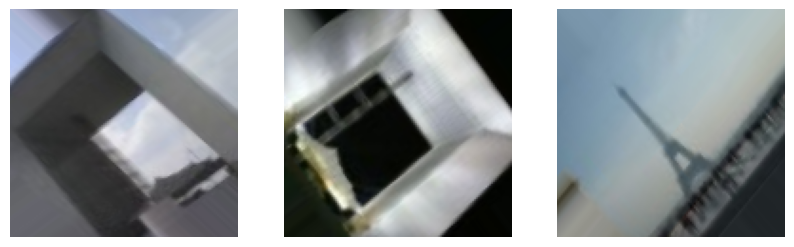

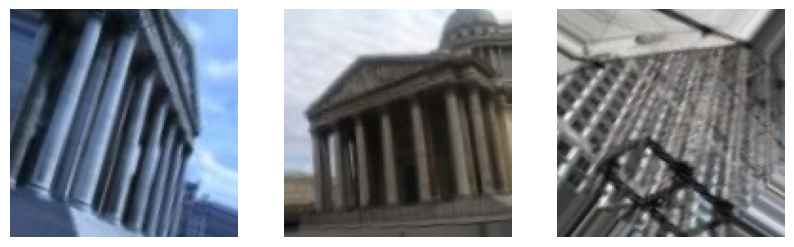

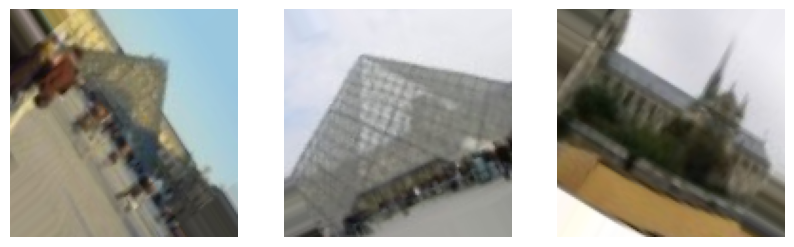

In [10]:
prt.stampa_tripletta(next(generatore_triplete_train))
prt.stampa_tripletta(next(generatore_triplete_train))
prt.stampa_tripletta(next(generatore_triplete_train))

# Definizione Modello Triple

In [11]:
def get_encoder (input_shape,trainable=False):
    
    base_cnn = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=input_shape,
        include_top=False)  # Do not include the ImageNet classifier at the top.
    
    base_cnn.trainable=trainable
    
    #trainable = False
    #for layer in base_cnn.layers:
    #    if layer.name == "conv5_block1_out":
    #        trainable = True
    #    layer.trainable = trainable
        
    encode_model = tf.keras.models.Sequential([
        base_cnn,
        layers.GlobalAveragePooling2D(),
     #   layers.Dense(512, activation="relu"),
     #   layers.BatchNormalization(),
     #   layers.Dense(256, activation="relu"),
     #   layers.BatchNormalization(),
        layers.Dense(32)
    ], name="Embedding")
    
    
    return encode_model

In [12]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [13]:
def get_siamese_network (input_shape = (120,120,3)):
    embedding_model = get_encoder(input_shape)
    input_anchor = tf.keras.layers.Input(shape= input_shape)
    input_positive = tf.keras.layers.Input(shape= input_shape)
    input_negative = tf.keras.layers.Input(shape= input_shape)
    
    embedding_anchor = embedding_model(resnet.preprocess_input(input_anchor))
    embedding_positive = embedding_model(resnet.preprocess_input(input_positive))
    embedding_negative = embedding_model(resnet.preprocess_input(input_negative))

    #embedding_anchor = embedding_model(input_anchor)
    #embedding_positive = embedding_model(input_positive)
    #embedding_negative = embedding_model(input_negative)

    distances = DistanceLayer()(
    embedding_anchor ,
    embedding_positive,
    embedding_negative ,
    )

    siamese_network =  tf.keras.models.Model(
    inputs=[input_anchor, input_positive, input_negative], outputs=distances
    )
    return siamese_network
    
siamese_network = get_siamese_network()  

In [14]:
class SiameseModel(tf.keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker =tf.keras.metrics.BinaryAccuracy(name ="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
        with tf.GradientTape() as tape:
            loss,acc = self._compute_loss(data)
        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, data):
        
        loss,acc = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss, (ap_distance<an_distance)
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker,self.acc_tracker]

In [15]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                      weighted_metrics=[]
                     )

In [17]:
#history = siamese_model.fit(triplet_train, epochs=1, validation_data=triplet_val)
PATIENCE_END=10
PATIENCE_REDUCE=3
COOLDOWN=3
VERBOSE=1
NAME="Xception"

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=PATIENCE_END,
                                                    mode='min')

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.5,
                                               patience=PATIENCE_REDUCE,
                                               verbose=VERBOSE,
                                               mode='auto',
                                               min_delta=0.01,
                                               cooldown=COOLDOWN,
                                               min_lr=1e-6
                                              )
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{NAME}")
# siccome uso un generator, la dimensione del dataset diventa potenzialmente infinita
# devo definire a quanti batch corrisponde un'epoca -> steps per epoch, validation steps
steps_train=int( x_train_len/batch_size )
steps_val=int(x_val_len/batch_size)

history = siamese_model.fit(
    generatore_triplete_train,
    steps_per_epoch=steps_train,
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    validation_data=generatore_triplete_val,
    validation_steps=steps_val,
    callbacks=[early_stopping,reduce_lr,tensorboard_callback]
    
)


Epoch 1/100
16/16 [==============================] - 178s 10s/step - loss: 0.4528 - acc: 0.6197 - val_loss: 0.3618 - val_acc: 0.6719 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 163s 10s/step - loss: 0.4382 - acc: 0.6287 - val_loss: 0.3678 - val_acc: 0.6992 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 161s 10s/step - loss: 0.4260 - acc: 0.6039 - val_loss: 0.4001 - val_acc: 0.6289 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4270 - acc: 0.6193
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 166s 10s/step - loss: 0.4270 - acc: 0.6192 - val_loss: 0.3830 - val_acc: 0.7031 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 162s 10s/step - loss: 0.4050 - acc: 0.6401 - val_loss: 0.3344 - val_acc: 0.7227 - lr: 5.0000e-04
Epoch 6/100
16/16 [==============================] - 162s 10s/step - loss: 0.4148 - acc: 0.6124 - val_loss: 0.36

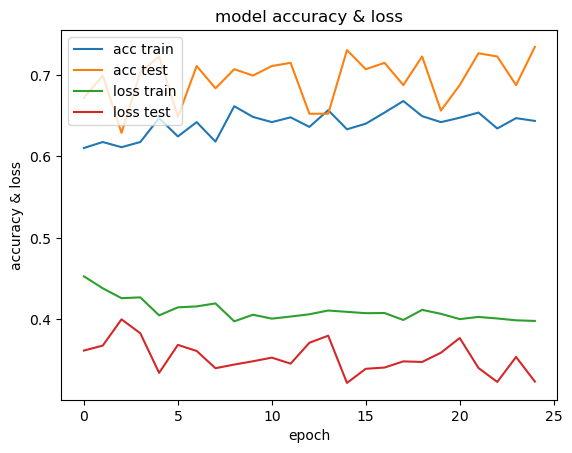

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc test', 'loss train','loss test'], loc='upper left')
plt.show()

# Usare il modello allenato

Runnare questa cella solo se non si ha il modello "encoder" salvato

In [20]:
def exctract_embedding(model):
    encoder=get_encoder((120,120,3))
    i=0
    for e_layer in model.layers[0].layers[9].layers:
        layer_weight= e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder
encoder=exctract_embedding(siamese_model)
encoder.save_weights("encoder_xception")
encoder.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 32)                65568     
                                                                 
Total params: 20,927,048
Trainable params: 65,568
Non-trainable params: 20,861,480
_________________________________________________________________


Runnare questa cella solo se si sono già calcolati i pesi per il modello "encoder"

In [ ]:
encoder=get_encoder((120,120,3))
encoder.load_weights("encoder_fineTuning")

Data un immagine in ingresso, trovare quale immagine appartenente al training set sia la più vicina, e classificare l'immagine in base al graound truth dell'immagine più simile

In [22]:
#Calcolo per ogni immagine del training set l'output attraverso l'encode
def makeX_Y_array (array):
    arr=[] #array 'senza buchi' 
    y_train= [] #array contenente la classe in base all'immagine
    y_levels=[] 
    previous=0
    for index in range(len(class_names)):
        arr.extend(array[index][0]) # [i] indica la classe [j] indica la qualita [k] la foto singola
        arr.extend(array[index][1]) #creo dataset di una sola classe con immagini solo good e ok
        totLen=len(array[index][0])+len(array[index][1])
        k= np.zeros(len(class_names))
        k[index]=1.0
        for el in range(totLen):
            y_train.append(k)
            
        y_levels.append(previous+totLen)
        previous=y_levels[index] # y_levels indica il valore più alto appartenente alla classe indicata da index
        
        print(y_levels)
    dt= tf.data.Dataset.from_tensor_slices(arr)
    y_train = tf.data.Dataset.from_tensor_slices (y_train)
    dt=dt.batch(32,drop_remainder=False)
    y_train=y_train.batch(32,drop_remainder=False)
    return dt, y_train,y_levels

In [23]:
dt,y_train,y_levels = makeX_Y_array(x_train)

[99]
[99, 148]
[99, 148, 294]
[99, 148, 294, 399]
[99, 148, 294, 399, 589]
[99, 148, 294, 399, 589, 647]
[99, 148, 294, 399, 589, 647, 737]
[99, 148, 294, 399, 589, 647, 737, 839]
[99, 148, 294, 399, 589, 647, 737, 839, 881]
[99, 148, 294, 399, 589, 647, 737, 839, 881, 997]
[99, 148, 294, 399, 589, 647, 737, 839, 881, 997, 1211]


In [24]:
points=encoder.predict(dt)

38/38 [==============================] - 16s 393ms/step


In [25]:
def classify_images(tensor):
    distance = tf.reduce_sum(tf.square(points - tensor), -1)
    return distance

def retrieve_mean_distance(tensor):
    distance = []    
    for index in range(len(class_names)):
        if index==0:
            diClasse=tensor[0:y_levels[index]]
        else:
            diClasse=tensor[y_levels[index-1]:y_levels[index]]
          
        distance.append( tf.math.reduce_min(diClasse) )  # per ritrovare la media basta mettere reduce_mean
    #toRet= tf.reduce_min(distance) 
    #distribution = tf.math.equal(distance,toRet)
    #distribution = tf.cast(distribution,tf.float32)
    distribution = tf.nn.softmax(distance)
    distribution =tf.subtract(distribution,1)
    distribution = tf.negative(distribution)
    distribution= tf.divide(distribution,len(distribution)-1)
    return distribution #l'indice della classe con la distanza media minore

class DistanceClassificationLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.points=points

    def call(self, tensor):
        #per ogni immagine vado a calcolare la distanza rispetto a tutti le foto del training set
        predicts = tf.map_fn(classify_images,tensor)
        #PER USARE LA MEDIA INVECE CHE IL MINIMO SCOMMENTRARE QUESTI 2 E COMMENTARE I 2 SUCCESSIVI
        test=tf.map_fn(retrieve_mean_distance,predicts)
        return test
        #predicts=tf.argmin(predicts,-1) #prendo l'indice dell'immagine rispetto al training set con la distanza minore
        #return retrieve_label(predicts) # ritrovo dall'indice la classe
    
       
evaluation_model=tf.keras.models.Sequential([encoder,DistanceClassificationLayer()]) 

Vado a creare un dataset dove (x_test, classi associata)

In [26]:
evaluate_dt,res,re_levels= makeX_Y_array(x_test)
evaluate_dt= tf.data.Dataset.zip((evaluate_dt,res))

[13]
[13, 19]
[13, 19, 37]
[13, 19, 37, 50]
[13, 19, 37, 50, 74]
[13, 19, 37, 50, 74, 81]
[13, 19, 37, 50, 74, 81, 93]
[13, 19, 37, 50, 74, 81, 93, 106]
[13, 19, 37, 50, 74, 81, 93, 106, 111]
[13, 19, 37, 50, 74, 81, 93, 106, 111, 126]
[13, 19, 37, 50, 74, 81, 93, 106, 111, 126, 153]


In [27]:
#evaluation_model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy()]) # qui ci andrebbe il topK ma non funziona
evaluation_model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy(),
                                  tf.keras.metrics.TopKCategoricalAccuracy(k=3)
                                 ]) # qui ci andrebbe il topK ma non funziona
evaluation_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Sequential)      (None, 32)                20927048  
                                                                 
 distance_classification_lay  (None, 11)               0         
 er (DistanceClassificationL                                     
 ayer)                                                           
                                                                 
Total params: 20,927,048
Trainable params: 65,568
Non-trainable params: 20,861,480
_________________________________________________________________


In [28]:
evaluation = evaluation_model.evaluate(evaluate_dt)

5/5 [==============================] - 3s 348ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.7124 - top_k_categorical_accuracy: 0.8824


In [ ]:
print(res)
print(len(evaluate_dt), len(evaluate_dt[0]), len(evaluate_dt[0][0]), len(evaluate_dt[0][0][0]))